# Como bien pone en el nombre del colab, esto es un intento honorable de hacer redes neuronales
### Para tamaño e inteligencia se hará de tipo clasificación, y para longevidad de tipo regresión.

## Librerías:

#### Sklearn

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

#### Keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, History, TensorBoard, Callback, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall

#### Habituales / Data

In [3]:
import pandas as pd
import numpy as np
import pickle

#### Viz

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

#### Warnings

In [15]:
import warnings
warnings.filterwarnings('ignore')

## Lectura datos

In [6]:
df = pd.read_csv('Datasets/data_for_ml.csv')
df.sample(3)

,Dog breed,lifetime_cost,intellingence_ranking,longevity,weight_kg,shoulder_height_cm,obey_first_command_%_of_time,Renta media/pers (€),Áreas caninas (m²),n_genetic_diseases,tricks_yes,size_category_enc,intelligence_category_enc,house_type_enc,owners_physical_activity_enc
1911,Alaskan Malamute,21266.458106,36.860827,10.594729,38.766669,62.852675,50,17026.0,1246.0,0,0.0,2.0,2.0,3.0,2.0
129,English Cocker Spaniel,18354.560028,80.443400,11.860933,13.712282,43.354753,30,20103.0,1764.0,0,0.0,1.0,4.0,1.0,1.0
596,Pointer,25814.060743,49.057156,12.723047,27.821279,71.570405,70,25956.0,623.0,1,1.0,2.0,4.0,2.0,1.0


## "X"s e "y"s de longevidad, tamaño e inteligencia:

#### Tamaño

In [7]:
X_tam = df[['Renta media/pers (€)', 'Áreas caninas (m²)', 'tricks_yes','house_type_enc','owners_physical_activity_enc']]
y_tam = df['size_category_enc']

#### Longevidad

In [8]:
X_lon = df[['size_category_enc', 'Renta media/pers (€)', 'Áreas caninas (m²)', 'tricks_yes','house_type_enc','owners_physical_activity_enc']]
y_lon = df['longevity']

#### Inteligencia

##### Inteligencia de 6 a 3 clases:

In [9]:
df['intelligence_category_enc'].unique()

mapping= {0:0, 1:0, 2:1, 3:1, 4:2, 5:2}

df['int_cat_enc_fixed'] = df['intelligence_category_enc'].map(mapping)

df['int_cat_enc_fixed'].unique()

array([2, 1, 0])

##### Xs e ys int

In [10]:
X_int = df[['size_category_enc', 'longevity', 'Renta media/pers (€)', 'Áreas caninas (m²)', 'tricks_yes','house_type_enc','owners_physical_activity_enc']]
y_int = df['int_cat_enc_fixed']

## Red Neuronal Regresión (Longevidad)

#### Escalado de las X

In [11]:
scaler_lon = StandardScaler()
X_lon_sc = scaler_lon.fit_transform(X_lon)

#### Modelo longevidad

In [12]:
def scheduler(epoch, lr):
    return lr * np.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

In [13]:
f_lon=X_lon_sc.shape[1]
f_lon

6

In [16]:
model_lon = Sequential()

model_lon.add(Dense(512, activation='relu', input_dim=f_lon)) ## relu es porque es regresión, y el input tiene que ir sólo en la primera capa.

model_lon.add(Dense(1)) # Capa de salida, tiene que ser solo 1, para que los datos converjan y tener sólo un resultado.

adam = Adam(learning_rate=.05) # La velocidad de aprendizaje del modelo por epoch.

model_lon.compile(optimizer=adam, loss='mse') #Compilando el modelo

La multicapa en este caso me da peor que con solo una capa

#### Entrenamiento con resultados

In [17]:
history = model_lon.fit(X_lon_sc, y_lon, batch_size=64, epochs=100, verbose=False, validation_split=.2, callbacks=[lr_schedule])

In [18]:
hist_lon_nosplit = pd.DataFrame(history.history)
hist_lon_nosplit['epoch'] = history.epoch

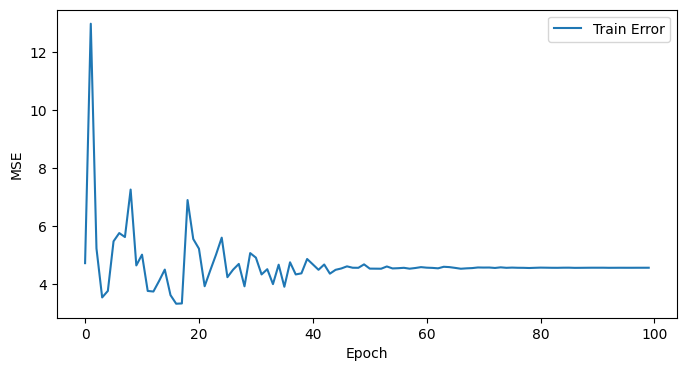

In [19]:
plt.figure(figsize=(8,4))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(hist_lon_nosplit['epoch'], hist_lon_nosplit['val_loss'], label='Train Error')
plt.legend()
plt.show()

In [20]:
y_pred_lon_nosplit = model_lon.predict(X_lon_sc)

68/68 [==============================] - 0s 321us/step


In [21]:
print(f'MAE:  {mean_absolute_error(y_lon, y_pred_lon_nosplit):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_lon, y_pred_lon_nosplit)):.2f}')

MAE:  1.04
RMSE: 1.40


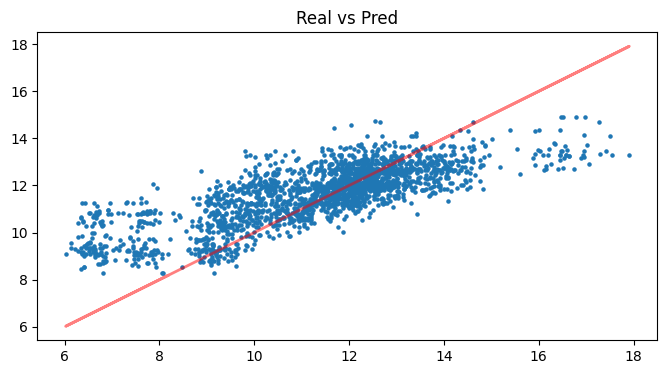

In [22]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(y_lon, y_lon, color='red', lw=2, alpha=.5)
plt.scatter(y_lon, y_pred_lon_nosplit, s=5)
plt.title('Real vs Pred')
plt.show()

In [ ]:
# pickle.dump(model_lon, open('modelo_rn_lon_2.pkl', 'wb'))

El modelo "**modelo_rn_lon_1.pkl**", red neuronal de 1 capa de entrada tipo relu (no me acuerdo del número neuronas creo 128), epoch 100, batch size 64 dió como MAE y RMSE lo siguiente:
- MAE: 1.03 años.
- RMSE: 1.35 años.

# Red Neuronal Clasificación (tamaño)

## Escalado de la X

In [23]:
scaler_tam = StandardScaler()
X_tam_sc = scaler_tam.fit_transform(X_tam)

## Modelo

In [24]:
f_tam = X_tam_sc.shape[1]

model_tam = Sequential()

# Capa entrada
model_tam.add(Dense(512, activation='relu', input_dim=f_tam))
# Capas intermedias (si hay):
model_tam.add(Dense(128, activation='tanh'))
#model_tam.add(Dropout(rate=0.3))
#Capa salida
model_tam.add(Dense(3, activation="softmax")) #como es clasificación multiclase la salida tiene que ser con softmax.

#Aprendizaje ratio
adam = Adam(learning_rate=.05)

#Compilación
model_tam.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# model_tam.summary()

In [25]:
history = model_tam.fit(
    X_tam_sc,
    y_tam,
    batch_size=64,
    epochs=200,
    verbose=False,
    validation_split=.2,
    callbacks=[lr_schedule]
)

In [26]:
y_pred_prob_tam = model_tam.predict(X_tam_sc)
y_pred_tam_classes = np.argmax(y_pred_prob_tam, axis=1)

68/68 [==============================] - 0s 394us/step


In [27]:
print(classification_report(y_tam, y_pred_tam_classes))

              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76       806
         1.0       0.57      0.59      0.58       599
         2.0       0.83      0.65      0.73       745

    accuracy                           0.70      2150
   macro avg       0.70      0.69      0.69      2150
weighted avg       0.71      0.70      0.70      2150



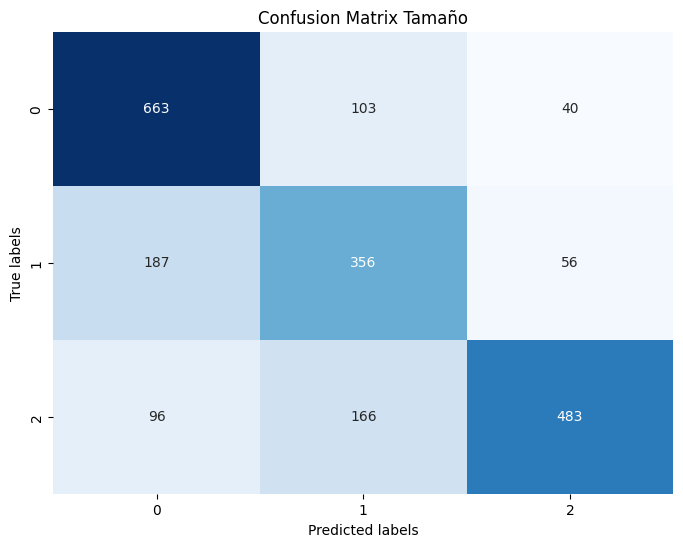

In [28]:
cm_rn = confusion_matrix(y_tam, y_pred_tam_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Tamaño")
plt.show()


In [29]:
pickle.dump(model_tam, open('Models/modelo_rn_tam_1.pkl', 'wb'))

La red neuronal para tamaño "**modelo_rn_tam_1.pkl**", de características: {Capa 1: relu, 512 neuronas, Capa 2: tanh, 128 neuronas y Capa salida: softmax, 3 neuronas} con 200 epochs, 64 de batch-size y un ratio de aprendizaje que empieza en 0.05 y va bajando conforme aumentan los epochs, ha dado la siguiente precisión:
- Precisión media: 0.70
- Precisión media ponderada: 0.71

# Red Neuronal Clasificación (Inteligencia)

## Escalado de la X

In [30]:
scaler_int = StandardScaler()
X_int_sc = scaler_int.fit_transform(X_int)

## Modelo

In [31]:
f_int = X_int_sc.shape[1]

model_int = Sequential()

# Capa entrada
model_int.add(Dense(512, activation='relu', input_dim=f_int))
# Capas intermedias (si hay):
model_int.add(Dense(128, activation='tanh'))
#model_tam.add(Dropout(rate=0.3))
#Capa salida
model_int.add(Dense(3, activation="softmax")) #como es clasificación multiclase la salida tiene que ser con softmax.

#Aprendizaje ratio
adam = Adam(learning_rate=.05)

#Compilación
model_int.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# model_tam.summary()

In [32]:
history = model_int.fit(
    X_int_sc,
    y_int,
    batch_size=64,
    epochs=200,
    verbose=False,
    validation_split=.2,
    callbacks=[lr_schedule]
)

In [33]:
y_pred_prob_int = model_int.predict(X_int_sc)
y_pred_int_classes = np.argmax(y_pred_prob_int, axis=1)

68/68 [==============================] - 0s 919us/step


In [34]:
print(classification_report(y_int, y_pred_int_classes))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       846
           1       0.64      0.85      0.73       778
           2       0.81      0.81      0.81       526

    accuracy                           0.73      2150
   macro avg       0.76      0.75      0.74      2150
weighted avg       0.75      0.73      0.73      2150



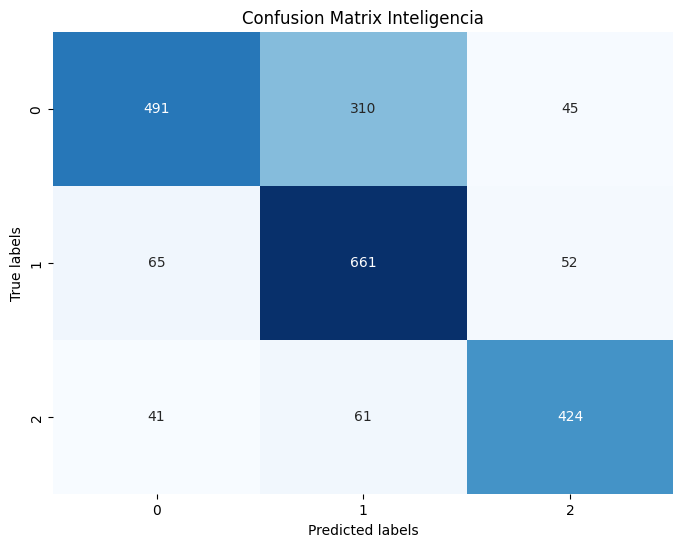

In [35]:
cm_rn = confusion_matrix(y_int, y_pred_int_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Inteligencia")
plt.show()


In [36]:
pickle.dump(model_int, open('Models/modelo_rn_int_1.pkl', 'wb'))

La red neuronal para inteligencia "**modelo_rn_int_1.pkl**", de características: {Capa 1: relu, 512 neuronas, Capa 2: tanh, 128 neuronas y Capa salida: softmax, 3 neuronas} con 200 epochs, 64 de batch-size y un ratio de aprendizaje que empieza en 0.05 y va bajando conforme aumentan los epochs, ha dado la siguiente precisión:
- Precisión media: 0.76
- Precisión media ponderada: 0.75